<a href="https://colab.research.google.com/github/brendanhasz/embedding-regression/blob/master/TFP_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tfp-nightly

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

np.random.seed(1234)
tf.set_random_seed(1234)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Fake Data

In [0]:
# Generate fake data
D = 4
N = 100
noise_std_true = 1.0
w_true = np.random.randn(D, 1).astype(np.float32)
b_true = np.random.randn(1).astype(np.float32)
x = np.random.randn(N, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N,1).astype(np.float32)
y = np.matmul(x, w_true) + b_true + noise

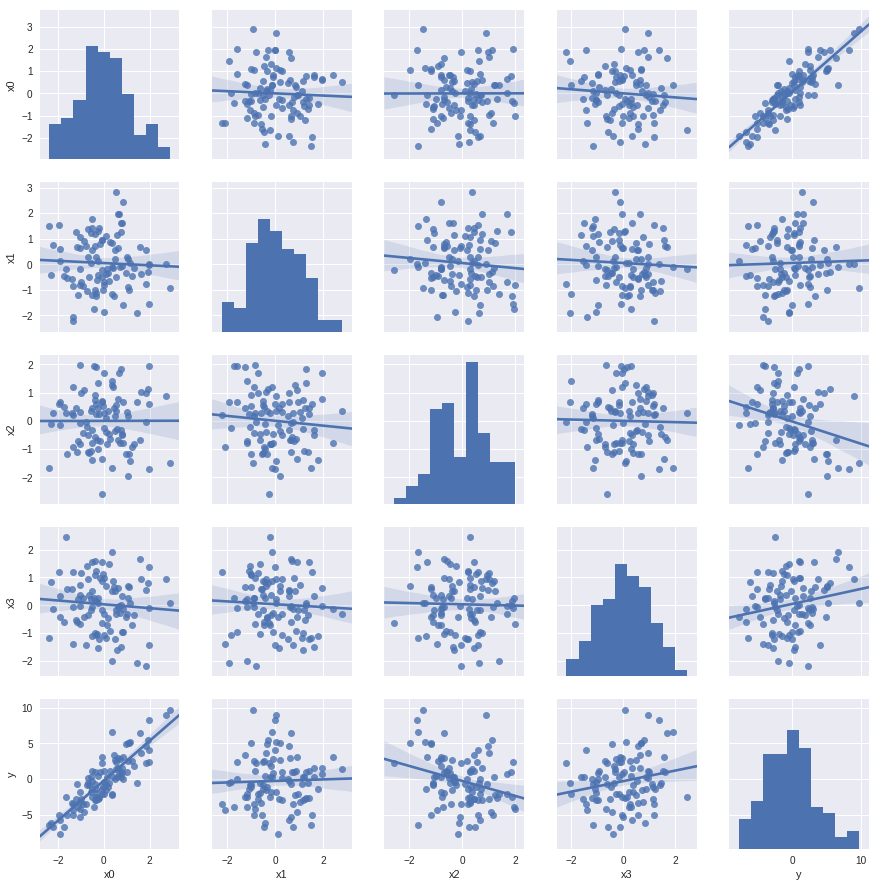

In [23]:
# Show data
cols = ['x0', 'x1', 'x2', 'x3', 'y']
sns.pairplot(pd.DataFrame(np.c_[x, y], columns=cols),
             kind='reg')
plt.show()

# Model

A basic Bayesian linear regression

\begin{align*}
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{HalfNormal}(1) \\
\alpha &\sim \text{Normal}(0, 1) \\
y_i &\sim \text{Normal}(\alpha + x_i^\top \beta, ~ \sigma^2)
\end{align*}



In [0]:
def linear_regression(features):
  """Bayesian linear regression, which returns predictions given features."""
  D = features.shape[1]
  coeffs = ed.Normal(        #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  bias = ed.Normal(          #normal prior on bias
      loc=tf.zeros([1]), 
      scale=tf.ones([1]),
      name="bias") 
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=tf.ones([1]),
      name="noise_std")
  predictions = ed.Normal(   #normally-distributed noise around predicted values
      loc=tf.matmul(features, coeffs)+bias,
      scale=noise_std,
      name="predictions")
  return predictions

log_joint = ed.make_log_joint_fn(linear_regression)

def target_log_prob_fn(coeffs, bias, noise_std):
  """Target density."""
  return log_joint(
      features=x,
      coeffs=coeffs,
      bias=bias,
      noise_std=noise_std,
      predictions=y)

# Bayesian Inference

Yadda yadda

In [26]:
# HMC Settings
num_results = int(10e3) #number of hmc iterations
n_burnin = int(5e3)     #number of burn-in steps
step_size = 0.05
num_leapfrog_steps = 2

# Parameter sizes
coeffs_size = [4,1]
bias_size = [1]
noise_std_size = [1]

t0 = time.time()

# HMC transition kernel
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps)

# Run the chain
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.zeros(bias_size, name='init_bias'),
        tf.ones(noise_std_size, name='init_noise_std'),
    ])

coeffs, bias, noise_std = states

with tf.Session() as sess:
  [
      coeffs_,
      bias_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      coeffs,
      bias,
      noise_std,
      kernel_results.is_accepted,
  ])


# Samples after burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
bias_samples = bias_[n_burnin:]
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

print('Elapsed time: ', time.time()-t0)

Elapsed time:  8.212403535842896


Talk about acceptance rate.  

Sounds like an acceptance rate of about 0.234 is "optimal".  http://dx.doi.org/10.1214/aoap/1034625254


In [27]:
print('Acceptance rate: ', np.mean(accepted_samples))

Acceptance rate:  0.986


TODO: talk about looking @ posterior distribution

dist is the posterior, solid line is true val, dotted lines show 95% conf interval

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

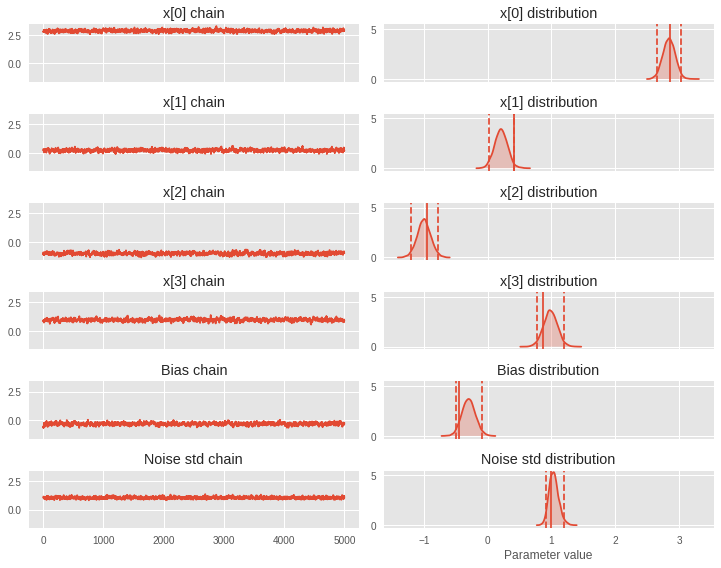

In [28]:
def chain_plot(data, title='', ax=None):
  if ax is None:
    ax = plt.gca()
  ax.plot(data)
  ax.title.set_text(title+" chain")
  
def post_plot(data, title='', ax=None, true=None, prc=95):
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
def chain_post_plot(data, title='', ax=None, true=None):
  chain_plot(data, title=title, ax=ax[0])
  post_plot(data, title=title, ax=ax[1], true=true)
  
# Plot chains and distributions for coefficients
plt.style.use("ggplot")
fig, axes = plt.subplots(D+2, 2, sharex='col', sharey='col')
fig.set_size_inches(10, 8)
for i in range(D):
  chain_post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i),
                  ax=axes[i], true=w_true[i])
  
# Plot chains and distributions for bias
chain_post_plot(bias_samples[:,0],
                title="Bias",
                ax=axes[D], true=b_true)

# Plot chains and distributions for noise std dev
chain_post_plot(noise_std_samples[:,0],
                title="Noise std",
                ax=axes[D+1], true=noise_std_true)
  
axes[D+1][1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

# Criticism

TODO

talk math, how you set the param values to the mean of their posterior dists, and then sample from the model, you can see "posterior predictive distributions" (but this is assuming the true params = the mean of the posterior, which the prediction interval above didn't)

Only captures aleatoric (noise) uncertainty.

Generate some held-out data


In [0]:
# Generate held out data
x_val = np.random.randn(N, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N, 1).astype(np.float32)
y_val = np.matmul(x_val, w_true) + b_true + noise

then intercept etc

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

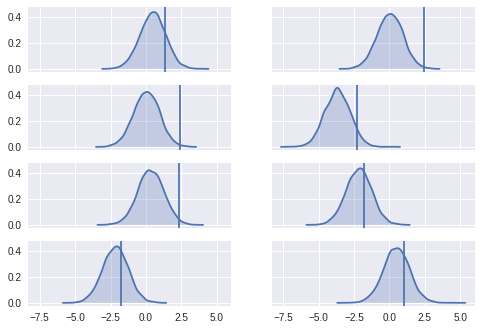

In [10]:
def interceptor(f, *args, **kwargs):
  name = kwargs.pop("name")
  if name == "coeffs":
    kwargs["value"] = np.reshape(np.mean(coeffs_samples, 0), (4,1))
  elif name == "noise_std":
    kwargs["value"] = np.mean(noise_std_samples, 0)
  return f(*args, **kwargs)

with ed.interception(interceptor):
  posterior = linear_regression(features=x_val)

with tf.Session() as sess:
  posterior_predictive = sess.run(
      posterior.distribution.sample(sample_shape=(5000)))

# Plot random datapoints and their posterior predictive intervals
sns.set()
fig, axes = plt.subplots(4, 2, sharex='all', sharey='all')
for i in range(4):
  for j in range(2):
    ix = np.random.randint(0, N)
    #ix = i*2+j
    sns.kdeplot(posterior_predictive[:,ix,0], shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])
    vals1 = posterior_predictive[:,ix,0]

TODO: then you can take the mean of the posterior predictive for each datapoint and plot the residuals.  In theory the residual distribution should look like the distribution you used to model the noise (in our case a normal distribution)

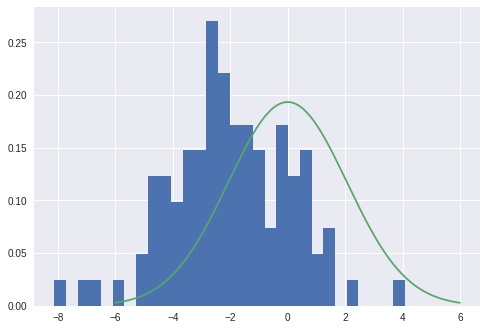

In [11]:
# Compute the mean posterior predictive for each datapoint
with tf.Session() as sess:
  residuals = sess.run(
      posterior.distribution.mean())
  
# Plot the residual distribution
plt.figure()
plt.hist(residuals[:,0], bins=30, density=True)
xx = np.linspace(-6, 6, 200)
plt.plot(xx, norm.pdf(xx, scale=np.std(residuals)))
plt.show()

Residuals look pretty good and match the noise distribution.

# Prediction intervals


Talk about both epistemic (model) + aleatoric (noise) uncertainty. 

"Intercepting" the models at the posterior means captures only noise uncertainty, but this is a bayesian fit, so we have access to the model uncertainty as well!

TODO (generate prediction intervals for test data)

TODO: then also do it via intercepting (w/i a loop over all the MCMC samples). talk about how that's a pretty ineffecient way to do it, but not sure if there's a better way w/ tensorflow probability.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


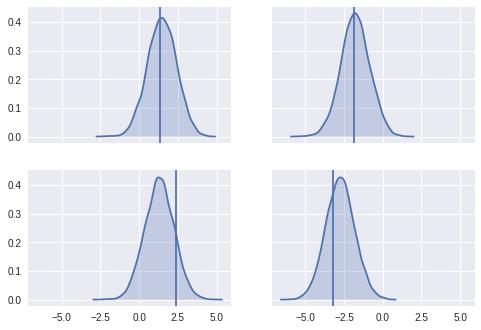

In [12]:
def prediction_distribution(X):
  # seems like there should be a way to do this like:
  #posterior = linear_regression(features=np.reshape(X, (len(X), 1)))
  #define param posterior vals somehow?
  # trying to do it w/ interceptor doesn't work, unless you change the interceptor and get a single sample each time...
  #with tf.Session() as sess:
  #  prediction_samples = sess.run(posterior.distribution.sample(sample_shape=(n)))  
  predictions = np.matmul(X, coeffs_samples.transpose()) + bias_samples[:,0]
  noise = noise_std_samples[:,0]*np.random.randn(noise_std_samples.shape[0])
  return predictions + noise

# Plot random datapoints and their prediction intervals
sns.set()
fig, axes = plt.subplots(2, 2, sharex='all', sharey='all')
for i in range(2):
  for j in range(2):
    #ix = np.random.randint(0, N)
    ix = i*2+j
    pred_dist = prediction_distribution(x_val[ix,:])
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])
    vals2 = pred_dist

# Bayesian Neural Network

cant do MCMC w/ full neural nets, would take too long, but can do variational! Talk about the upsides (fast) but also the downsides (assumes all params posteriors are independent)

We'll use a super-simple Bayesian neural network and ensure it comes up with the same uncertainty as the previous model which we fit with MCMC

TODO: net diagram

In [13]:
def toy_linear_data(num_examples, input_size=2, noise_std=1.0):
  """Generates synthetic data using a simple linear model.
  Args:
    num_examples: The number of samples to generate (scalar Python `int`).
    input_size: The input space dimension (scalar Python `int`).
  Returns:
    random_weights: Sampled weights as a Numpy `array` of shape
      `[input_size]`.
    random_bias: Sampled bias as a scalar Python `float`.
    design_matrix: Points sampled from a normal distribution of 
      shape `(num_examples,input_size)`.
    values: Values sampled from the linear model `p(label) =
      Normal(dot(features, random_weights) + random_bias, noise_std)`, as a 
      Numpy `float` `array` of shape `(num_examples, 1)`.
  """
  random_weights = np.random.randn(input_size)
  random_bias = np.random.randn()
  random_noise = noise_std * np.random.randn(num_examples)
  design_matrix = np.random.randn(num_examples, input_size)
  values = np.float32(np.reshape(
      np.dot(design_matrix, random_weights) + random_bias + random_noise,
      (-1, 1)))
  return random_weights, random_bias, np.float32(design_matrix), values

def build_input_pipeline(x, y, batch_size):
  """Build a Dataset iterator for supervised classification.
  Args:
    x: Numpy `array` of features, indexed by the first dimension.
    y: Numpy `array` of labels, with the same first dimension as `x`.
    batch_size: Number of elements in each training batch.
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  """
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.repeat().batch(batch_size)
  training_iterator = training_batches.make_one_shot_iterator()
  batch_features, batch_labels = training_iterator.get_next()
  return batch_features, batch_labels




# Generate (and visualize) a toy classification dataset.
#N = 1000
#D = 4
batch_size = 128
max_steps = 1500
learning_rate = 0.01
#noise_std_true = 1.0
#w_true, b_true, x, y = toy_linear_data(N, D, noise_std_true)
x_vals, y_vals = build_input_pipeline(x, y, batch_size)

# A linear regression model as a Normal distribution
# parameterized by location from a single linear layer.
with tf.name_scope("linear_regression", values=[x_vals]):
  layer = tfp.layers.DenseFlipout(
      units=1, 
      activation=None,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())
  predictions = layer(x_vals)
  noise_std = tf.get_variable("noise_std", shape=[1])
  pred_distribution = tfd.Normal(loc=predictions, scale=noise_std)

# Compute the -ELBO as the loss, averaged over the batch size
neg_log_likelihood = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl = sum(layer.losses) / N
elbo_loss = neg_log_likelihood + kl

# Mean squared error metric for evaluation
mse, mse_update_op = tf.metrics.mean_squared_error(
    labels=y_vals, predictions=predictions)

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

# To store parameter values over training
weight_mean = layer.kernel_posterior.mean()[:,0]
weight_std = layer.kernel_posterior.stddev()[:,0]
bias_mean = layer.bias_posterior.mean()
bias_std = layer.bias_posterior.stddev()
weight_means = np.zeros((max_steps, D))
weight_stds = np.zeros((max_steps, D))
bias_means = np.zeros(max_steps)
bias_stds = np.zeros(max_steps)
noise_stds = np.zeros(max_steps)
mses = np.zeros(max_steps)
losses = np.zeros(max_steps)

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  for iS in range(max_steps):
    [
        _,
        _,
        mses[iS],
        losses[iS],
        weight_means[iS,:],
        weight_stds[iS,:],
        bias_means[iS],
        bias_stds[iS],
        noise_stds[iS]
    ] = sess.run([
        train_op,
        mse_update_op,
        mse,
        elbo_loss,
        weight_mean,
        weight_std,
        bias_mean,
        bias_std,
        noise_std
    ])

  # Draw from the weights posterior
  Nmc = 1000
  w_draw = layer.kernel_posterior.sample(Nmc)
  b_draw = layer.bias_posterior.sample(Nmc)
  w_post, b_post = sess.run([w_draw, b_draw])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Let's visualize the posterior distributions which were computed using variational fit.

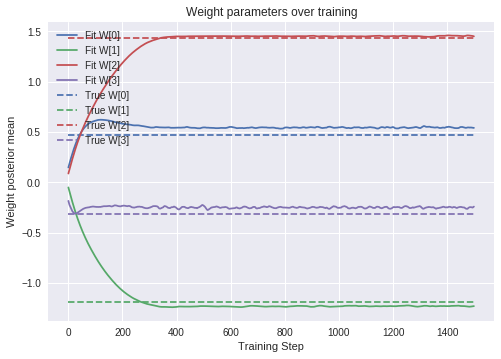

In [14]:
# Plot value of weights over training
plt.figure()
for iW in range(D):
  plt.plot(weight_means[:,iW], label='Fit W[{}]'.format(iW), 
           color=colors[iW])
  plt.hlines(w_true[iW], 0, max_steps, label='True W[{}]'.format(iW), 
             color=colors[iW], linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Weight posterior mean')
plt.title('Weight parameters over training')
plt.legend()
plt.show()

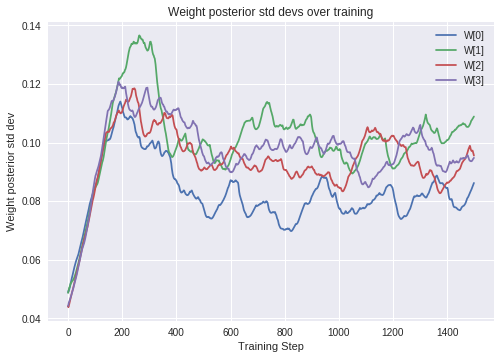

In [15]:
# Plot value of weight std devs over training
plt.figure()
for iW in range(D):
  plt.plot(weight_stds[:,iW], label='W[{}]'.format(iW), 
           color=colors[iW])
plt.xlabel('Training Step')
plt.ylabel('Weight posterior std dev')
plt.title('Weight posterior std devs over training')
plt.legend()
plt.show()

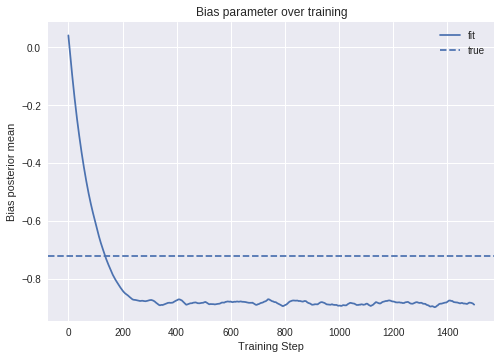

In [16]:
# Plot value of bias over training
plt.figure()
plt.plot(bias_means, label='fit')
plt.axhline(b_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior mean')
plt.title('Bias parameter over training')
plt.legend()
plt.show()

make sure the std dev doesn't shrink to 0 w/ more training?

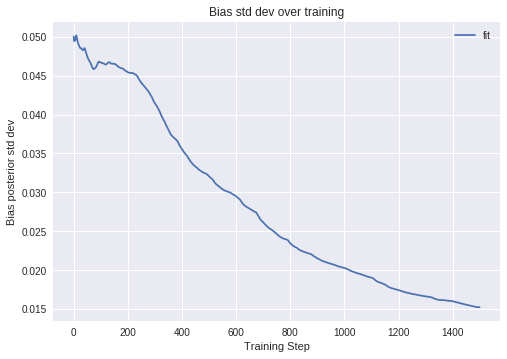

In [17]:
# Plot value of bias std dev over training
plt.figure()
plt.plot(bias_stds, label='fit')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior std dev')
plt.title('Bias std dev over training')
plt.legend()
plt.show()

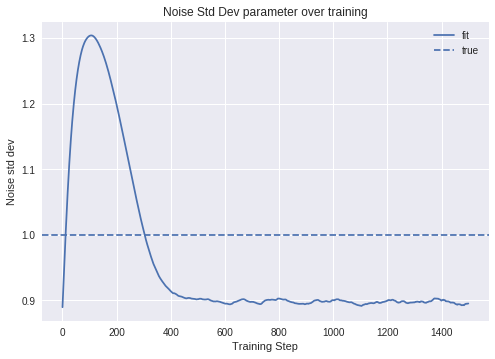

In [18]:
# Plot value of noise std dev over training
plt.figure()
plt.plot(noise_stds, label='fit')
plt.axhline(noise_std_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Noise std dev')
plt.title('Noise Std Dev parameter over training')
plt.legend()
plt.show()

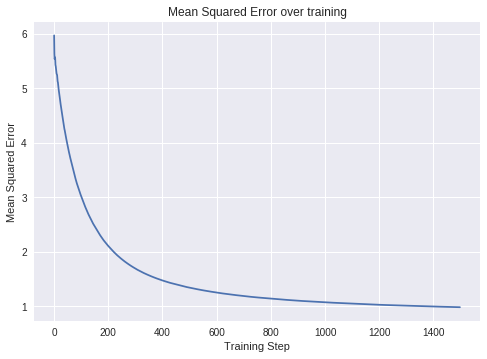

In [19]:
# Plot mean squared error over training
plt.figure()
plt.plot(mses[1:])
plt.xlabel('Training Step')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error over training')
plt.show()

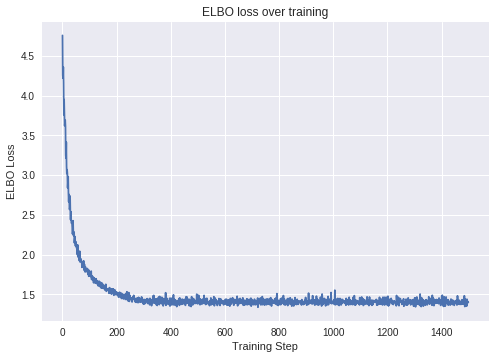

In [20]:
# Plot ELBO loss over training
plt.figure()
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('ELBO Loss')
plt.title('ELBO loss over training')
plt.show()

And we can also take a look at the posterior distributions for the weight and bias parameters (at the end of training).

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

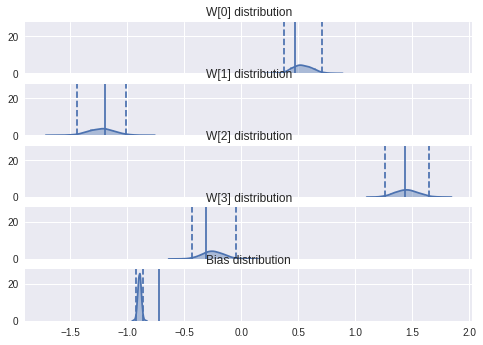

In [21]:
def post_plot(data, title='', ax=None, true=None, prc=95):
  if ax is None:
    ax = plt.gca()
  sns.distplot(data, ax=ax)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)

# Plot weight posteriors
sns.set()
fig, axes = plt.subplots(D+1, 1, sharex='all', sharey='all')
for i in range(D):
  post_plot(w_post[:,i,0], title='W[{}]'.format(i), 
            ax=axes[i], true=w_true[i])
  
# Plot Bias posterior
post_plot(b_post[:,0], title='Bias', 
          ax=axes[D], true=b_true)
plt.show()

In [0]:
TODO: figure out why both methods are underestimating the bias?  
  is that just randomness in the 100 datapoints?
  Hmm yeah re-ran w/ a different seed and it does fine.  Must just be the default seed weird.
  
TODO: plot variational posteriors against MCMC posteriors given same data
  
TODO: prediction intervals? and how do they match up to the MCMC-generated prediction intervals?

Outline: 

- MCMC linear model
- Variational linear model ("simple neural net")
- multi-layer neural net (but w/ constant noise term, use on taxi trip dataset and measure coverage of the 95% conf interval)
- 2 module multi-layer neural net (one to predict mean, other to predict variance), show how it can predict when noise increases in a simple heteroscedastic example, then use on taxi trip duration data! and see if it makes the coverage of the 95% conf interval closer to 95%!